In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# import UCRB boundaries
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [3]:
# Daily and annual HCDN streamflow and basin characteristics
hcdn_daily_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_chars_and_daily_q.nc')
hcdn_annual_q = xr.open_dataset('../data/streamflowdata/hcdn_basin_annual_q.nc').drop('dim_1')

# HCDN seasonal precipitation
hcdn_seasonal_ppt = xr.open_dataset('../data/precipdata/prism_hcdn_seasonal_ppt.nc')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.sel(dim_1='ppt')
hcdn_seasonal_ppt = hcdn_seasonal_ppt.rename({'__xarray_dataarray_variable__':'ppt','variable':'site_no'})
hcdn_seasonal_ppt = hcdn_seasonal_ppt.where(~hcdn_seasonal_ppt.site_no.isin(['09306242','09378170','09378630']),drop=True)
hcdn_seasonal_ppt['year'] = hcdn_seasonal_ppt.month.dt.year.where(hcdn_seasonal_ppt.month.dt.month<10, hcdn_seasonal_ppt.month.dt.year+1)
hcdn_annual_ppt = hcdn_seasonal_ppt.groupby('year').sum()

# UCRB monthly precipitation
prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')
prism_4km_all_ds = prism_4km_all_ds.rename({'__xarray_dataarray_variable__':'ppt'})
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'ppt':'p_km3'})

# UCRB naturalized streamflow
ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()

In [4]:
hcdn_daily_q.groupby('WY').min()['q_mm_day']/hcdn_daily_q.groupby('WY').mean()['q_mm_day']

<xarray.DataArray 'q_mm_day' (WY: 118, site_no: 26)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.08185373, 0.15123396, 0.27362849, ..., 0.        , 0.06201581,
        0.22688337],
       [0.0739639 , 0.22252695, 0.39015913, ..., 0.        , 0.07811647,
        0.21337166],
       [0.07260484, 0.09231514, 0.40453672, ..., 0.        , 0.10406537,
        0.24543339]])
Coordinates:
  * site_no  (site_no) object '09034900' '09035900' ... '09352900' '09361500'
  * WY       (WY) int64 1902 1903 1904 1905 1906 ... 2018 2019 2020 2021 2022

In [5]:
bfi = ((hcdn_daily_q.groupby('WY').min()['q_mm_day']/hcdn_daily_q.groupby('WY').mean()['q_mm_day']).mean(dim='WY')*100)

In [6]:

lag_1_autocorr = {}
for site in hcdn_annual_q.site_no.values:
    lag_1_autocorr[site] = sm.tsa.acf(hcdn_annual_q.sel(site_no=site)['q_mm'].to_pandas().dropna())[1]



In [7]:
# look at runoff efficiency 
runoff_efficiency = xr.open_dataarray('../data/streamflowdata/hcdn_runoff_efficiency.nc')

In [8]:
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100

cv_df = pd.concat([hcdn_daily_q["q_mm_day"].sel(site_no=site).groupby(hcdn_daily_q.date.dt.month).mean().to_dataframe().rename(columns={'q_mm_day':site})[site] for site in hcdn_daily_q.site_no.values], axis=1)

Text(0.5, 1.05, 'Baseflow Index vs Runoff Efficiency and Coefficient of Variation')

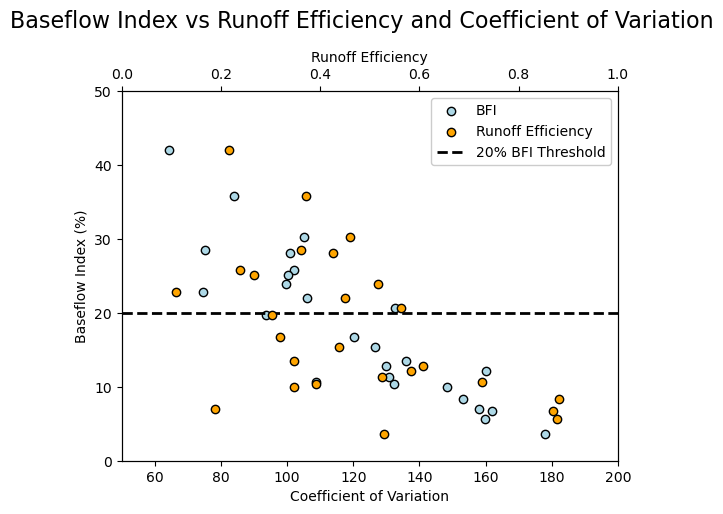

In [31]:
fig,ax = plt.subplots()
ax2= ax.twiny()
ax2.scatter( runoff_efficiency.mean(dim='year').values,
            bfi.values,
            color='orange',
            ec='k')

ax.scatter(cv_df.apply(cv), 
           bfi.values,
           color='lightblue',
           ec='k', 
           label='BFI',
           zorder=0)
ax.scatter([],[], 
           color='orange',
           ec='k', 
           label='Runoff Efficiency')
ax.set_xlabel('Coefficient of Variation')
ax.set_ylabel('Baseflow Index (%)')
ax.set_xlim(50,200)
ax.set_ylim(0,50)
ax.axhline(20, label='20% BFI Threshold', lw=2, color='k', ls='--')


ax2.set_xlabel('Runoff Efficiency')
ax2.set_xlim(0,1)
ax.legend(framealpha=1, loc='upper right')
fig.suptitle('Baseflow Index vs Runoff Efficiency and Coefficient of Variation', size=16, y=1.05)

Text(0.5, 1.05, 'Baseflow Index vs Runoff Efficiency and Coefficient of Variation')

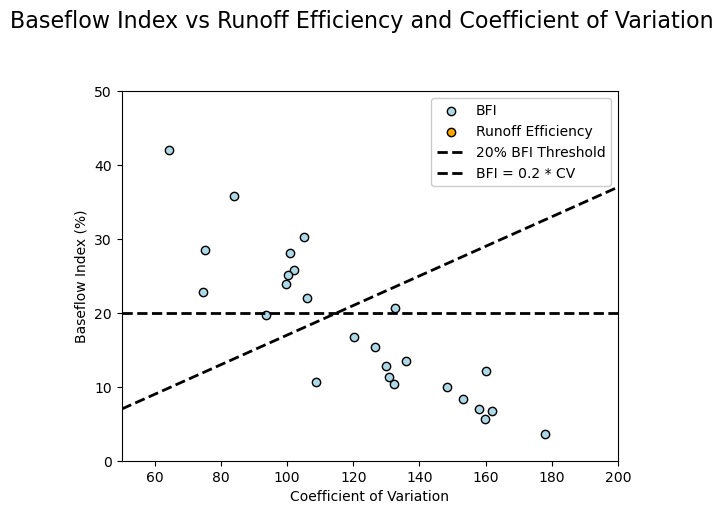

In [38]:
fig,ax = plt.subplots()

ax.scatter(cv_df.apply(cv), 
           bfi.values,
           color='lightblue',
           ec='k', 
           label='BFI',
           zorder=0)
ax.scatter([],[], 
           color='orange',
           ec='k', 
           label='Runoff Efficiency')
ax.set_xlabel('Coefficient of Variation')
ax.set_ylabel('Baseflow Index (%)')
ax.set_xlim(50,200)
ax.set_ylim(0,50)
ax.axhline(20, label='20% BFI Threshold', lw=2, color='k', ls='--')
# add a line normal to the slope of the BFI vs CV line
x = np.linspace(50,200,26)
y = 0.2*x-3
# create a filter for all points above the line
response_speed_filter = (bfi.values > y)
ax.plot(x,y, color='k', ls='--', lw=2, label='BFI = 0.2 * CV')



ax.legend(framealpha=1, loc='upper right')
fig.suptitle('Baseflow Index vs Runoff Efficiency and Coefficient of Variation', size=16, y=1.05)

### Separate into fast and slow response basins based on 20% base flow index
- can also test with a 0.15 threshold for lag-1 autocorrelation

In [40]:
slow_response = bfi.where(bfi>=y, drop=True).site_no.values
fast_response = bfi.where(bfi<y, drop=True).site_no.values

In [41]:
center_of_mass_date = {}
for year in hcdn_daily_q.WY.to_series().unique():
    example = hcdn_daily_q.where(hcdn_daily_q.WY==year,drop=True)['q_mm_day'].cumsum(dim='date')
    com_value = example.max(dim='date')/2
    center_of_mass_date[year] = abs(example - com_value).idxmin(dim='date').dt.dayofyear.to_dataframe()
    
center_of_mass_date_da = xr.Dataset(center_of_mass_date).to_array().squeeze()
center_of_mass_date_da = center_of_mass_date_da.where((center_of_mass_date_da>52) & (center_of_mass_date_da<238))
center_of_mass_date_da = center_of_mass_date_da.rename({'variable':'year'})
center_of_mass_date_da.name = 'flow_com'

In [42]:
hcdn_annual_q = hcdn_annual_q.merge(center_of_mass_date_da)

In [43]:
slow_response_daily_q = hcdn_daily_q.where(hcdn_daily_q.site_no.isin(slow_response), drop=True)
fast_response_daily_q = hcdn_daily_q.where(hcdn_daily_q.site_no.isin(fast_response), drop=True)

slow_response_mean_q = hcdn_annual_q.where(hcdn_annual_q.site_no.isin(slow_response), drop=True)
fast_response_mean_q = hcdn_annual_q.where(hcdn_annual_q.site_no.isin(fast_response), drop=True)

In [44]:
conf = 0.05

### Hypothesis test if slow and fast response basins show differences in the timing of center of mass 

In [45]:
slow_response_com_ttest_results = pd.DataFrame(index=slow_response_mean_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in slow_response_mean_q.site_no.values:
    single_site_pre = slow_response_mean_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = slow_response_mean_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    slow_response_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        slow_response_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        slow_response_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            slow_response_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            slow_response_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        slow_response_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        slow_response_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            slow_response_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            slow_response_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [46]:
slow_response_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.668986,Probably Gaussian,0.004,Null Hypothesis Rejected,NaN,NaN
09047700,0.001588,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.022,Null Hypothesis Rejected
09066000,0.405575,Probably Gaussian,0.089,Null Hypothesis Accepted,NaN,NaN
09107000,0.155155,Probably Gaussian,0.102,Null Hypothesis Accepted,NaN,NaN
09110000,0.000799,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.174,Null Hypothesis Accepted
09115500,0.007756,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.081,Null Hypothesis Accepted
09119000,0.000425,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.345,Null Hypothesis Accepted
09183500,0.224348,Probably Gaussian,0.139,Null Hypothesis Accepted,NaN,NaN
09304500,0.000008,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.002,Null Hypothesis Rejected


In [47]:
fast_response_com_ttest_results = pd.DataFrame(index=fast_response_mean_q.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in fast_response_mean_q.site_no.values:
    single_site_pre = fast_response_mean_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[:1999]
    single_site_post = fast_response_mean_q.sel(site_no=site)['flow_com'].to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    fast_response_com_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        fast_response_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        fast_response_com_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            fast_response_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            fast_response_com_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        fast_response_com_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        fast_response_com_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            fast_response_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            fast_response_com_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [48]:
fast_response_com_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.892358,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09065500,0.977676,Probably Gaussian,0.003,Null Hypothesis Rejected,NaN,NaN
09066200,0.496821,Probably Gaussian,0.002,Null Hypothesis Rejected,NaN,NaN
09066300,0.91807,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09081600,0.450326,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN
09112500,0.68582,Probably Gaussian,0.007,Null Hypothesis Rejected,NaN,NaN
09124500,0.468374,Probably Gaussian,0.0,Null Hypothesis Rejected,NaN,NaN
09132500,0.817359,Probably Gaussian,0.327,Null Hypothesis Accepted,NaN,NaN
09146200,0.211981,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09147500,0.120365,Probably Gaussian,0.822,Null Hypothesis Accepted,NaN,NaN


### Hypothesis test that AMJJ flow would has decreased in fast-response basins but not as much in slow-response basins. 
Hypothesis is that this earlier season flow would be reduced if this basin is a fast-responder, meaning that earlier season precipitation makes a difference here and the response to decreasing spring P may influence it. 

In [49]:
slow_response_amjj  = slow_response_daily_q.where(slow_response_daily_q.date.dt.month.isin([4,5,6,7,8,9]),drop=True)
slow_response_amjj_mean = slow_response_amjj['q_mm_day'].groupby(slow_response_amjj.date.dt.year).mean()

In [50]:
slow_response_qmean_ttest_results = pd.DataFrame(index=slow_response_amjj_mean.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in slow_response_amjj_mean.site_no.values:
    single_site_pre = slow_response_amjj_mean.sel(site_no=site).to_pandas().dropna().loc[:1999]
    single_site_post = slow_response_amjj_mean.sel(site_no=site).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    slow_response_qmean_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        slow_response_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        slow_response_qmean_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            slow_response_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            slow_response_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        slow_response_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        slow_response_qmean_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            slow_response_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            slow_response_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [51]:
slow_response_qmean_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09035900,0.179329,Probably Gaussian,0.323,Null Hypothesis Accepted,NaN,NaN
09047700,0.008429,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.303,Null Hypothesis Accepted
09066000,0.354507,Probably Gaussian,0.085,Null Hypothesis Accepted,NaN,NaN
09107000,0.153051,Probably Gaussian,0.132,Null Hypothesis Accepted,NaN,NaN
09110000,0.15472,Probably Gaussian,0.001,Null Hypothesis Rejected,NaN,NaN
09115500,0.097191,Probably Gaussian,0.088,Null Hypothesis Accepted,NaN,NaN
09119000,0.000662,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.029,Null Hypothesis Rejected
09183500,0.236302,Probably Gaussian,0.021,Null Hypothesis Rejected,NaN,NaN
09304500,0.704921,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN


In [52]:
fast_response_amjj  = fast_response_daily_q.where(fast_response_daily_q.date.dt.month.isin([4,5,6,7,8,9]),drop=True)
fast_response_amjj_mean = fast_response_amjj['q_mm_day'].groupby(fast_response_amjj.date.dt.year).mean()

In [53]:
fast_response_qmean_ttest_results = pd.DataFrame(index=fast_response_amjj_mean.site_no.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result'])
for site in fast_response_amjj_mean.site_no.values:
    single_site_pre = fast_response_amjj_mean.sel(site_no=site).to_pandas().dropna().loc[:1999]
    single_site_post = fast_response_amjj_mean.sel(site_no=site).to_pandas().dropna().loc[2000:]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    fast_response_qmean_ttest_results.loc[site,'Shapiro-Wilke p'] = p

    if p > conf:
        fast_response_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        z_alpha = stats.norm.ppf(conf)
        # print("z_alpha = {}".format(z_alpha)) 

        s_pooled = np.sqrt((single_site_pre.std(ddof=1)**2)/len(single_site_pre) +
                        (single_site_post.std(ddof=1)**2)/len(single_site_post))
        # print('Pooled standard deviation is {} mm'.format(str(s_pooled)))

        # null hypothesis: no change in sample means
        delta = 0*single_site_pre.mean()
        # compute test statistic
        z_test = ((single_site_post.mean()-single_site_pre.mean())-
                delta)/s_pooled
        # print("z-score = {}".format(np.round(z_test,2))) 
        # compute p value
        pvalue = stats.norm.cdf(z_test)
        fast_response_qmean_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            fast_response_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Rejected'
        else: 
            fast_response_qmean_ttest_results.loc[site,'t-test Result'] = 'Null Hypothesis Accepted'
    else:
        fast_response_qmean_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian''Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        fast_response_qmean_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            fast_response_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Rejected'
        else: 
            fast_response_qmean_ttest_results.loc[site,'mannwhitney Result'] = 'Null Hypothesis Accepted'

In [54]:
fast_response_qmean_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result
09034900,0.27505,Probably Gaussian,0.039,Null Hypothesis Rejected,NaN,NaN
09065500,0.220916,Probably Gaussian,0.059,Null Hypothesis Accepted,NaN,NaN
09066200,0.279773,Probably Gaussian,0.02,Null Hypothesis Rejected,NaN,NaN
09066300,0.064656,Probably Gaussian,0.024,Null Hypothesis Rejected,NaN,NaN
09081600,0.245916,Probably Gaussian,0.045,Null Hypothesis Rejected,NaN,NaN
09112500,0.454668,Probably Gaussian,0.006,Null Hypothesis Rejected,NaN,NaN
09124500,0.037738,"Probably GaussianProbably not Gaussian, consid...",NaN,NaN,0.041,Null Hypothesis Rejected
09132500,0.132009,Probably Gaussian,0.015,Null Hypothesis Rejected,NaN,NaN
09146200,0.883904,Probably Gaussian,0.042,Null Hypothesis Rejected,NaN,NaN
09147500,0.104949,Probably Gaussian,0.005,Null Hypothesis Rejected,NaN,NaN


In [55]:
# filter fast_response_qmean_ttest_result for sites with t-test p < 0.05 or mannwhitney p < 0.05
fast_response_qmean_accepted = fast_response_qmean_ttest_results[(fast_response_qmean_ttest_results['t-test p'] > 0.05) | (fast_response_qmean_ttest_results['mannwhitney p'] > 0.05)].index.values
fast_response_com_accepted = fast_response_com_ttest_results[(fast_response_com_ttest_results['t-test p'] > 0.05) | (fast_response_com_ttest_results['mannwhitney p'] > 0.05)].index.values

# filter fast_response_qmean_ttest_result for sites with t-test p < 0.05 or mannwhitney p < 0.05
fast_response_qmean_rejected = fast_response_qmean_ttest_results[(fast_response_qmean_ttest_results['t-test p'] < 0.05) | (fast_response_qmean_ttest_results['mannwhitney p'] < 0.05)].index.values
fast_response_com_rejected = fast_response_com_ttest_results[(fast_response_com_ttest_results['t-test p'] < 0.05) | (fast_response_com_ttest_results['mannwhitney p'] < 0.05)].index.values

In [56]:
# filter slow_response_qmean_ttest_result for sites with t-test p < 0.05 or mannwhitney p < 0.05
slow_response_qmean_rejected = slow_response_qmean_ttest_results[(slow_response_qmean_ttest_results['t-test p'] < 0.05) | (slow_response_qmean_ttest_results['mannwhitney p'] < 0.05)].index.values
slow_response_com_rejected = slow_response_com_ttest_results[(slow_response_com_ttest_results['t-test p'] <= 0.05) | (slow_response_com_ttest_results['mannwhitney p'] <= 0.05)].index.values

# filter slow_response_qmean_ttest_result for sites with t-test p < 0.05 or mannwhitney p < 0.05
slow_response_qmean_accepted = slow_response_qmean_ttest_results[(slow_response_qmean_ttest_results['t-test p'] >= 0.05) | (slow_response_qmean_ttest_results['mannwhitney p'] >= 0.05)].index.values
slow_response_com_accepted = slow_response_com_ttest_results[(slow_response_com_ttest_results['t-test p'] > 0.05) | (slow_response_com_ttest_results['mannwhitney p'] > 0.05)].index.values

### Plot fast response basins by results from t-test

Text(137, 18, '')

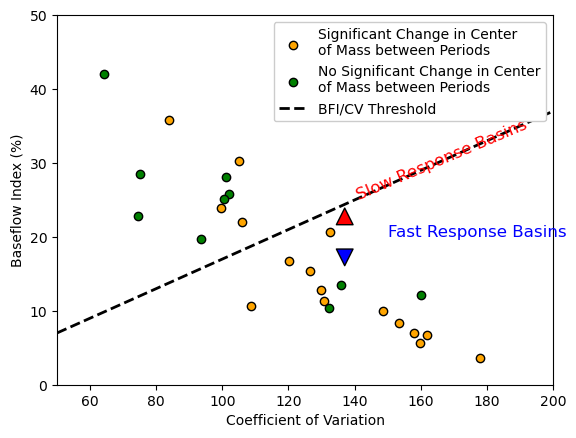

In [71]:
fig,ax = plt.subplots()
# ax2= ax.twiny()
# ax2.scatter( runoff_efficiency.mean(dim='year').values,
#             bfi.values,
#             color='orange',
#             ec='k')
# ax.scatter([],[], 
#            color='orange',
#            ec='k', 
#            label='Runoff Efficiency')
ax.scatter(cv_df.apply(cv).loc[fast_response_com_rejected], 
           bfi.sel(site_no=fast_response_com_rejected).values,
           color='orange',
           ec='k', 
           label='Significant Change in Center\nof Mass between Periods',
           zorder=0)

ax.scatter(cv_df.apply(cv).loc[slow_response_com_accepted], 
           bfi.sel(site_no=slow_response_com_accepted).values,
           color='green',
           ec='k', 
           label='No Significant Change in Center\nof Mass between Periods',
           zorder=0)

ax.scatter(cv_df.apply(cv).loc[fast_response_com_accepted], 
           bfi.sel(site_no=fast_response_com_accepted).values,
           color='green',
           ec='k',
           zorder=0)

ax.scatter(cv_df.apply(cv).loc[slow_response_com_rejected], 
           bfi.sel(site_no=slow_response_com_rejected).values,
           color='orange',
           ec='k', 
           zorder=0)

ax.set_xlabel('Coefficient of Variation')
ax.set_ylabel('Baseflow Index (%)')
ax.set_xlim(50,200)
ax.set_ylim(0,50)
# ax.axhline(20, label='20% BFI Threshold', lw=2, color='k', ls='--')
# add a line normal to the slope of the BFI vs CV line
x = np.linspace(50,200,26)
y = 0.2*x-3
# create a filter for all points above the line
response_speed_filter = (bfi.values > y)
ax.plot(x,y, color='k', ls='--', lw=2, label='BFI/CV Threshold')

# ax2.set_xlabel('Runoff Efficiency')
# ax2.set_xlim(0,1)
ax.legend(framealpha=1, loc='upper right')
# add text above the BFI/CV threshold line to indicate slow response basins above the line and fast response basins below the line
ax.annotate('Slow Response Basins', xy=(140, 25), xytext=(140, 25), color='red', fontsize=12, rotation=23)
ax.annotate('Fast Response Basins', xy=(150, 20), xytext=(150, 20), color='blue', fontsize=12)


# add an arrow above slow resposne basins text pointing up
ax.annotate('', xy=(137, 24), xytext=(137, 22), arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('', xy=(137, 16), xytext=(137, 18), arrowprops=dict(facecolor='blue', shrink=0.05))

Text(137, 18, '')

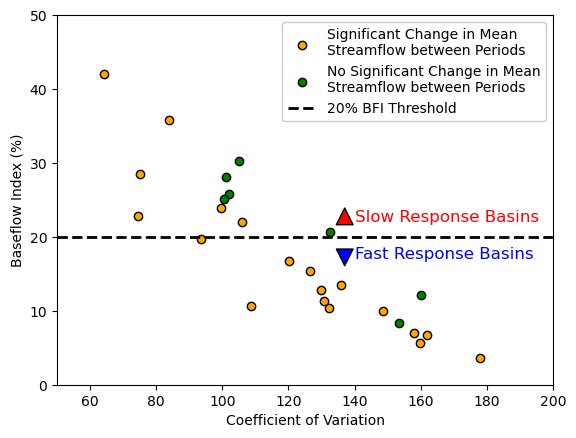

In [58]:
fig,ax = plt.subplots()
# ax2= ax.twiny()
# ax2.scatter( runoff_efficiency.mean(dim='year').values,
#             bfi.values,
#             color='orange',
#             ec='k')
# ax.scatter([],[], 
#            color='orange',
#            ec='k', 
#            label='Runoff Efficiency')
ax.scatter(cv_df.apply(cv).loc[fast_response_qmean_rejected], 
           bfi.sel(site_no=fast_response_qmean_rejected).values,
           color='orange',
           ec='k', 
           label='Significant Change in Mean\nStreamflow between Periods',
           zorder=0)

ax.scatter(cv_df.apply(cv).loc[slow_response_qmean_accepted], 
           bfi.sel(site_no=slow_response_qmean_accepted).values,
           color='green',
           ec='k', 
           label='No Significant Change in Mean\nStreamflow between Periods',
           zorder=0)

ax.scatter(cv_df.apply(cv).loc[fast_response_qmean_accepted], 
           bfi.sel(site_no=fast_response_qmean_accepted).values,
           color='green',
           ec='k',
           zorder=0)

ax.scatter(cv_df.apply(cv).loc[slow_response_qmean_rejected], 
           bfi.sel(site_no=slow_response_qmean_rejected).values,
           color='orange',
           ec='k', 
           zorder=0)

ax.set_xlabel('Coefficient of Variation')
ax.set_ylabel('Baseflow Index (%)')
ax.set_xlim(50,200)
ax.set_ylim(0,50)
ax.axhline(20, label='20% BFI Threshold', lw=2, color='k', ls='--')


# ax2.set_xlabel('Runoff Efficiency')
# ax2.set_xlim(0,1)
ax.legend(framealpha=1, loc='upper right')
# add text above the 20% BFI threshold line to indicate slow response basins above the line and fast response basins below the line
ax.text(140, 22, 'Slow Response Basins', fontsize=12, color='red')
ax.text(140, 17, 'Fast Response Basins', fontsize=12, color='blue')
# add an arrow above slow resposne basins text pointing up
ax.annotate('', xy=(137, 24), xytext=(137, 22), arrowprops=dict(facecolor='red', shrink=0.05))
ax.annotate('', xy=(137, 16), xytext=(137, 18), arrowprops=dict(facecolor='blue', shrink=0.05))

In [59]:
bfi.where(~bfi.site_no.isin(fast_response_qmean_accepted), drop=True)

<xarray.DataArray 'q_mm_day' (site_no: 24)>
array([ 6.70701799, 20.66824109, 30.30428205, 12.18822613,  5.68582891,
        3.56392662, 12.74652486, 28.10484533, 28.49288791, 15.38946504,
       25.75364148, 22.82576632, 16.74178456, 10.41310004, 23.92875058,
       19.77303913, 11.29640507, 42.00318723, 10.02826277, 13.43754965,
       35.7820649 ,  7.01031116, 10.5905499 , 21.99492307])
Coordinates:
  * site_no  (site_no) object '09034900' '09035900' ... '09352900' '09361500'